In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM
from pydil.utils.igmm_modif import IGMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load('toy_non_linear_100d_dataset.npy')

In [3]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [4]:
X.shape, y.shape, d.shape

((6000, 100), (6000,), (6000,))

In [5]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [6]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [7]:
combined_arrays = list(zip(Xt, yt))

random.seed(0)
# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [8]:
n_samples = 1000
batch_size = 200
n_atoms = 3
n_classes = 10

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==n_domains-1)[0], :], y[np.where(d==n_domains-1)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [10]:
OGMM = IGMM(min_components=10, max_step_components=5, max_components=20)

n_batch = 20
i=0
while i < Xt.shape[0]-n_batch:
    OGMM.train(Xt[i:i+n_batch, :])
    i += n_batch

OGMM.get_GMM()

[[0.00426287951671542,
  array([102.99700928,  66.20175171,  80.56668091,  29.27534866,
          39.07358551, -12.14475632,  28.4488163 , -23.93899155,
          30.74619293,  61.67564774, -39.19389343,  20.77811623,
          25.34971619,  73.95597076,  40.67886734,  -4.27120733,
          46.17824554,  75.39969635,  36.3585701 , 115.2306366 ,
          -2.57845283,  33.38934326,   2.13576388,  31.51704025,
          19.43578148,  -6.99309969,  78.47937775,  37.94474792,
          56.31156921,  31.15898132,  59.69762802,  26.61457253,
          10.81035042,  67.79776764, -15.379529  ,   4.38204908,
           1.5310514 , 102.94353485,  78.64385986,  91.48413086,
           7.85302401,  -0.77035993,  62.54741287, -58.41576004,
          88.32352448,  28.72201538,  57.57772064,  44.04408264,
          64.57301331,  33.77316666,  10.02214241,  10.24636745,
          75.19659424,  48.34533691,  54.8119812 , -14.5124979 ,
          19.83077431,   9.72930527, -15.85223007,   9.10066223,
  

In [11]:
%%script false --no-exec

range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))

dim_reduction = 3
n_gaussians = 10
OGMM = Online_GMM(
    n_components=n_gaussians, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction
OGMM.get_GMM()

Couldn't find program: 'false'


In [12]:
n_gaussians = 10
sklearn_GMM = GaussianMixture(n_components=n_gaussians, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=10, random_state=0)

## Tests on the GMM

In [ ]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

In [33]:
np.sum(OGMM.score_samples(Xt), bib='torch')

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\igmm_modif.py:566: RuntimeWarning: divide by zero encountered in log
  return -len(x)/2*np.log(2*np.pi) - 1/2*(np.log(np.linalg.det(cov)) + (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


TypeError: sum() got an unexpected keyword argument 'bib'

In [29]:
np.sum(sklearn_GMM.score_samples(Xt))

538462.0220630182

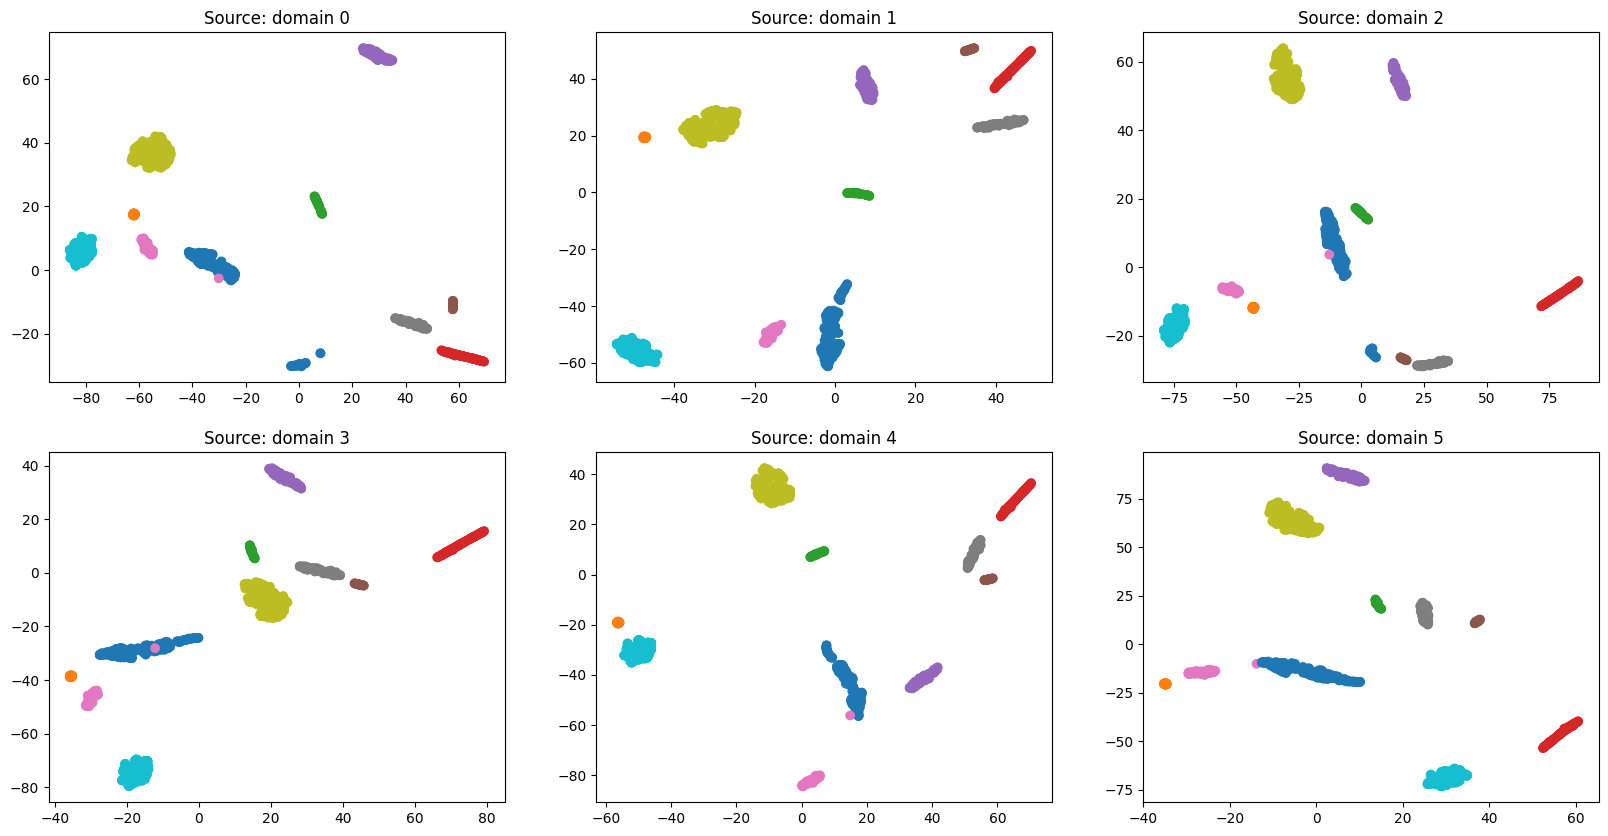

In [30]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')


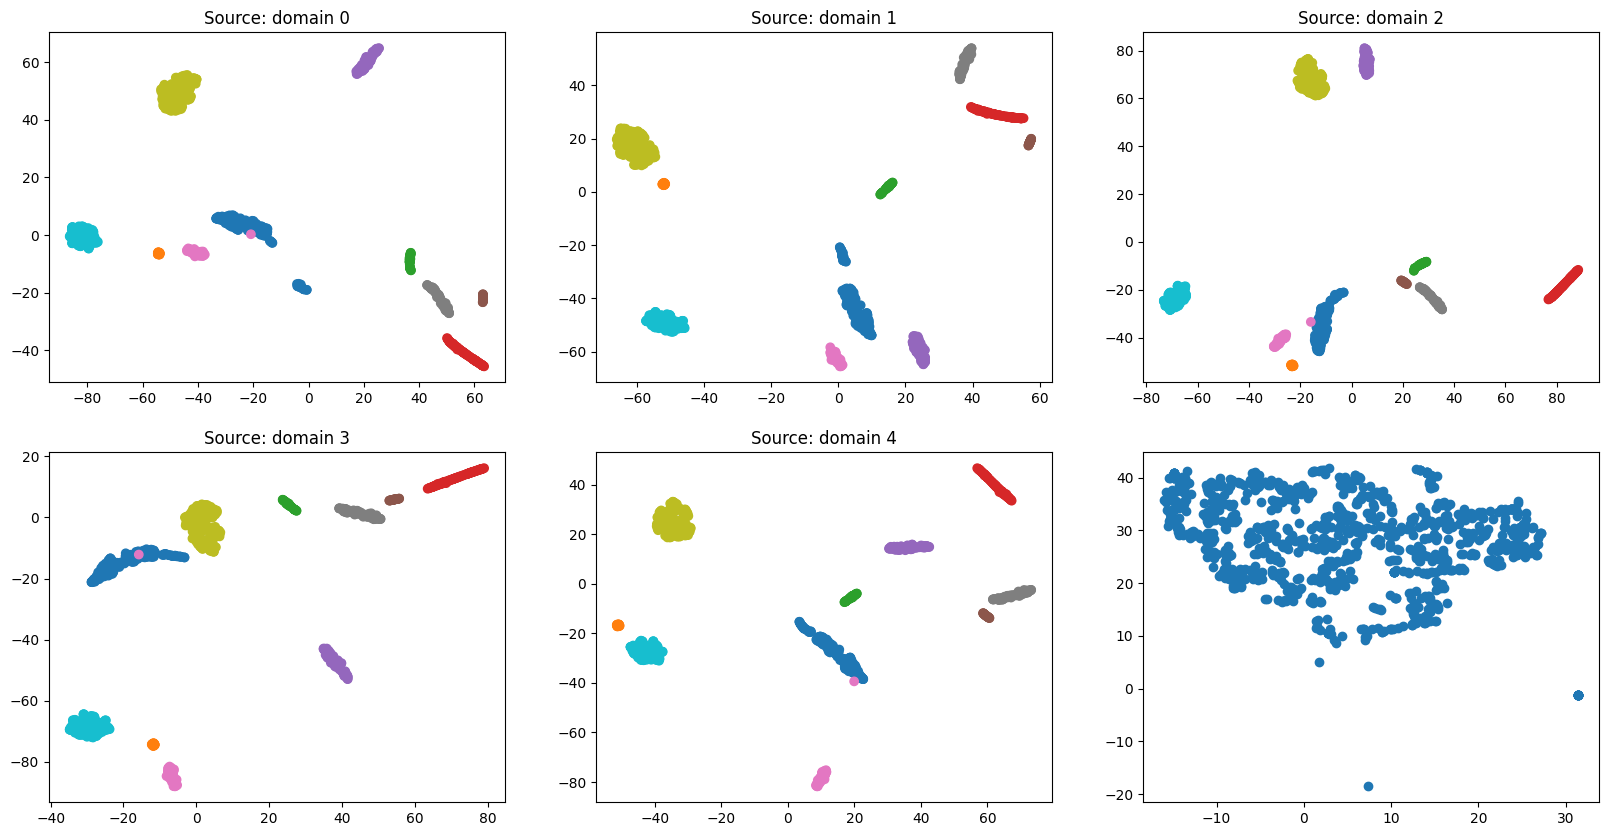

In [31]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

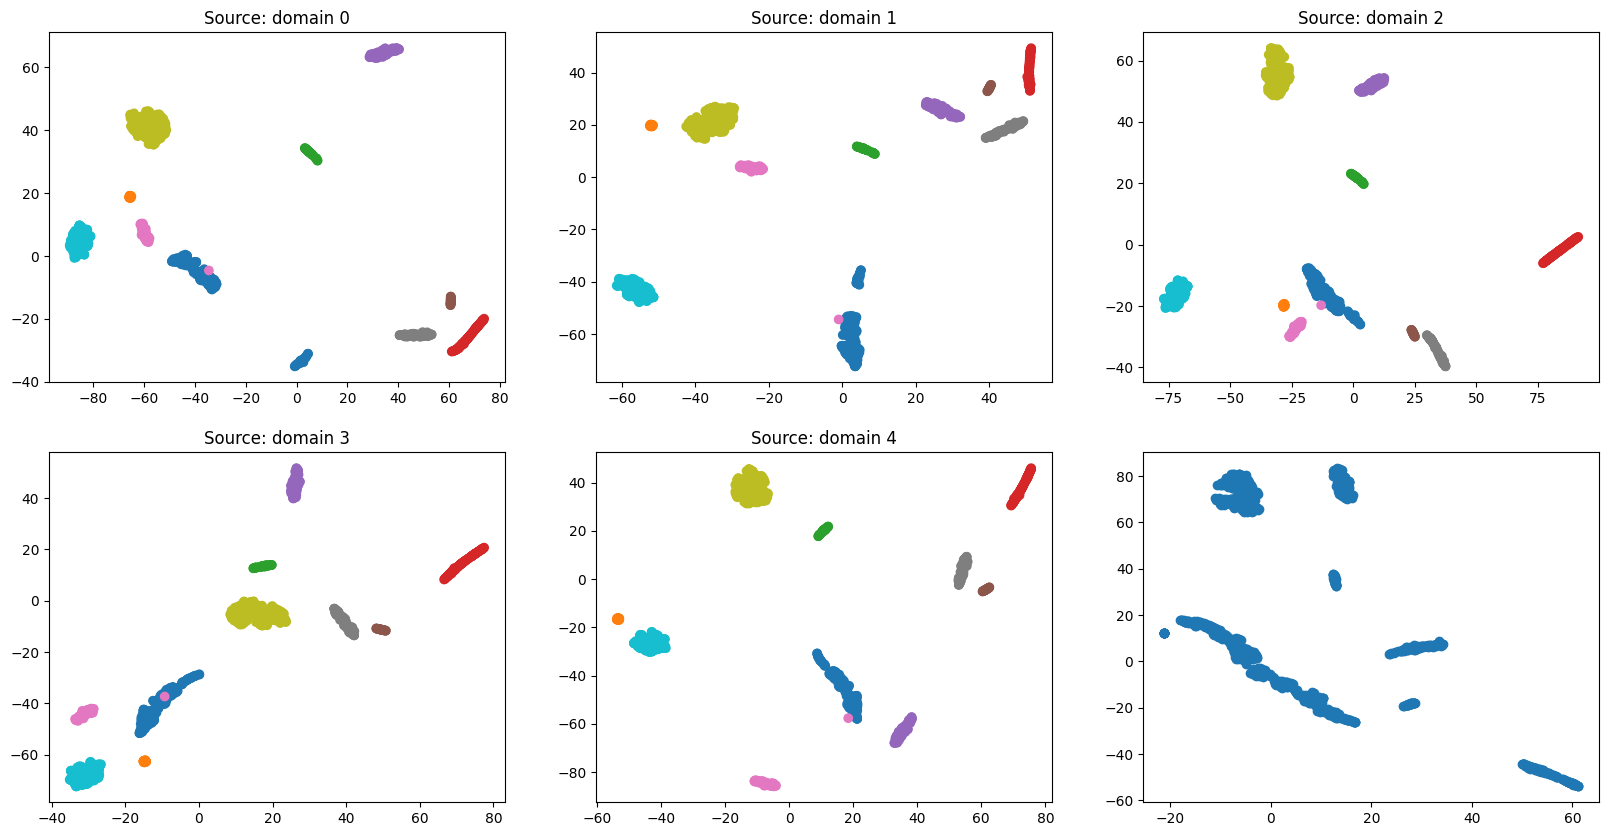

In [32]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(1000)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

Test to determine the best n_gaussians

In [ ]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

n_gaussians = np.linspace(10, 60, 6)
ll = []
for n_gauss in n_gaussians:
    OGMM = Online_GMM(
        n_components=n_gauss, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.get_GMM())
    ll.append(OGMM.score_samples(X_test_target_t, dimension_reduction=True))

## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [14]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

criterion = JointWassersteinDistance()

dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary_sources.fit(Q_sources,
               n_iter_max=80,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/80, Loss: 6123968.6
It 2/80, Loss: 4083276.3
It 3/80, Loss: 2697642.6500000004
It 4/80, Loss: 1940556.5
It 5/80, Loss: 1667291.525
It 6/80, Loss: 1538389.8250000002
It 7/80, Loss: 1444517.625
It 8/80, Loss: 1432710.45
It 9/80, Loss: 1400787.4499999997
It 10/80, Loss: 1399898.225
It 11/80, Loss: 1375531.95
It 12/80, Loss: 1366019.9
It 13/80, Loss: 1346505.075
It 14/80, Loss: 1335319.95
It 15/80, Loss: 1341060.9
It 16/80, Loss: 1332393.025
It 17/80, Loss: 1314432.4000000001
It 18/80, Loss: 1301917.05
It 19/80, Loss: 1293543.075
It 20/80, Loss: 1304618.875
It 21/80, Loss: 1289180.775
It 22/80, Loss: 1283586.3499999999
It 23/80, Loss: 1262820.775
It 24/80, Loss: 1270785.725
It 25/80, Loss: 1256396.175
It 26/80, Loss: 1250391.375
It 27/80, Loss: 1264009.625
It 28/80, Loss: 1232465.175
It 29/80, Loss: 1216959.75
It 30/80, Loss: 1234251.825
It 31/80, Loss: 1231383.9000000001
It 32/80, Loss: 1221837.125
It 33/80, Loss: 1204336.725
It 34/80, Loss: 1189901.05
It 35/80, Loss: 1201269.875
It 

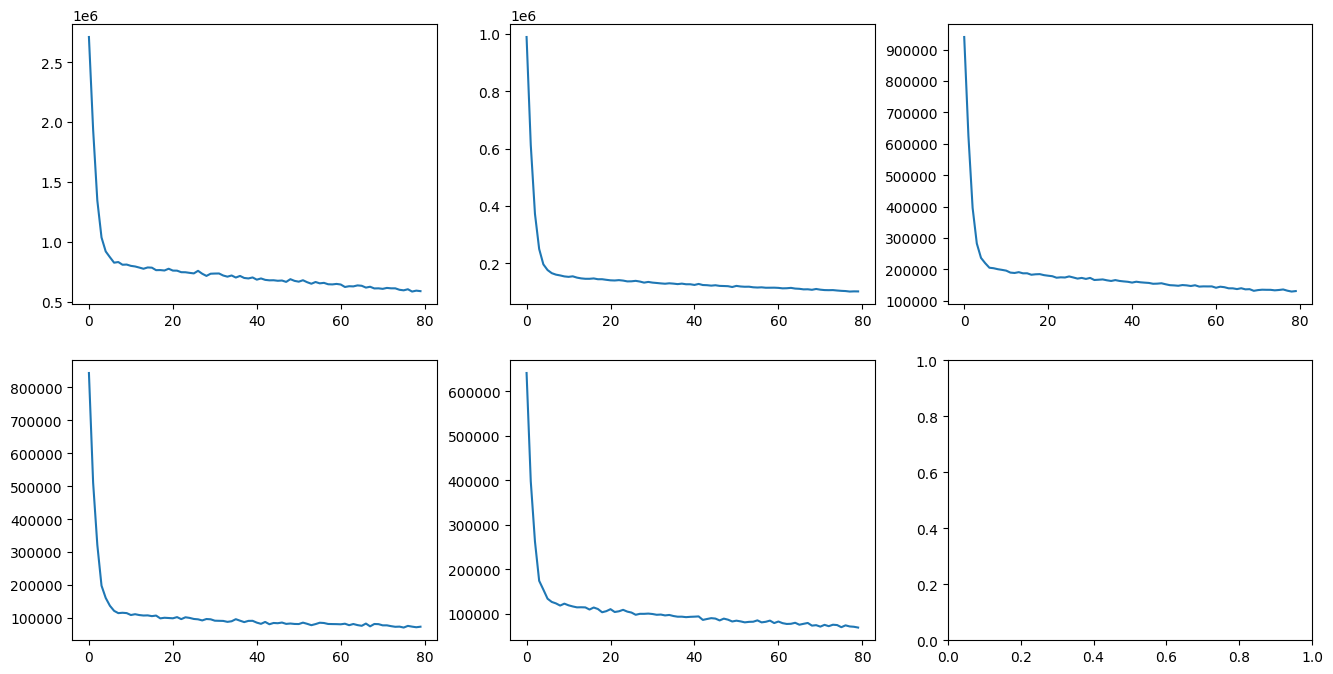

In [15]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

names_sources = [f'domain {i}' for i in range(6)]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

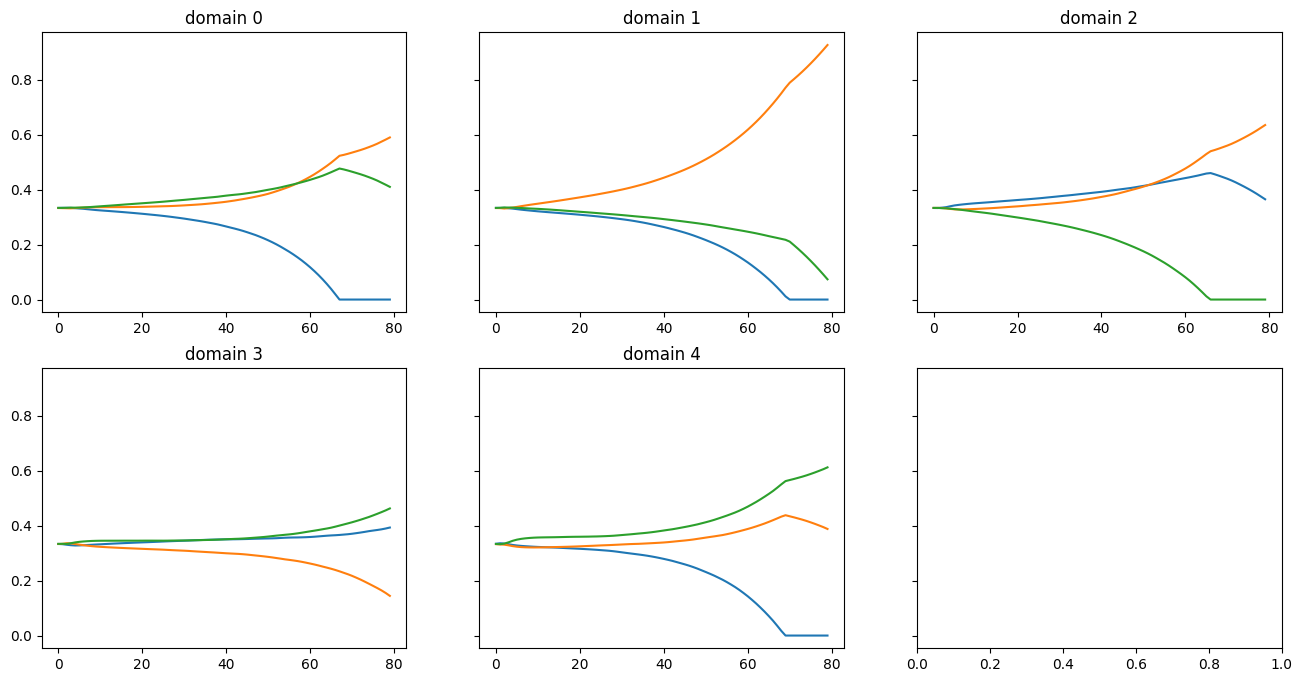

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [17]:
dim_reduction = 20
range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))


In [18]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=n_gaussians,
                           GMM_dim_reduction=dim_reduction,
                           data_range=range_data)

i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 119515.91874999998
20
Loss: 111577.7296875
40
Loss: 115777.43593749999
60
Loss: 114966.48749999999
80
Loss: 110489.3390625
100
Loss: 114320.7484375
120
Loss: 110935.1515625
140
Loss: 112947.33124999999
160
Loss: 113810.5859375
180
Loss: 115810.415625
200
Loss: 114278.02187499999
220
Loss: 111649.1609375
240
Loss: 116120.75468750001
260
Loss: 112963.4828125
280
Loss: 112540.9234375
300
Loss: 112902.17499999999
320
Loss: 113387.7875
340
Loss: 114556.8921875
360
Loss: 110294.6703125
380
Loss: 107745.29375
400
Loss: 107096.534375
420
Loss: 112201.3375
440
Loss: 110615.2265625
460
Loss: 109023.10625000001
480
Loss: 121152.31406250002
500
Loss: 123820.46875
520
Loss: 115528.26406249999
540
Loss: 117708.9203125
560
Loss: 113427.8015625
580
Loss: 111039.1625
600
Loss: 118460.79375000001
620
Loss: 114184.9125
640
Loss: 115802.3703125
660
Loss: 111782.3765625
680
Loss: 114930.1390625
700
Loss: 115989.5375
720
Loss: 113756.86562499999
740
Loss: 117154.703125
760
Loss: 112081.73281249999
7

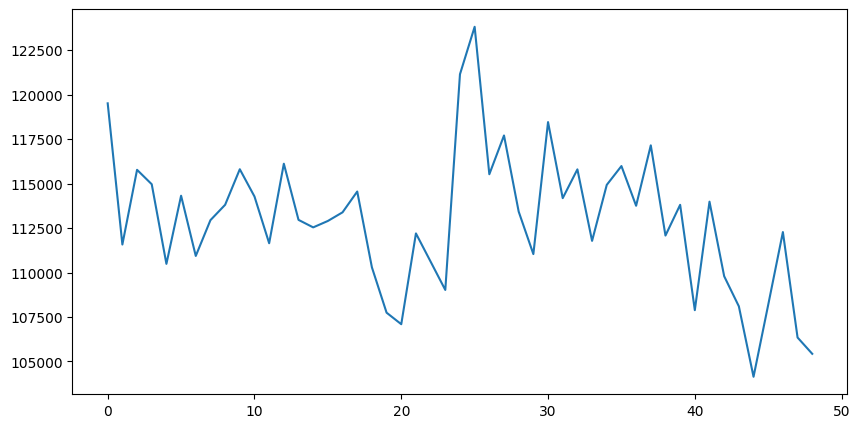

In [19]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

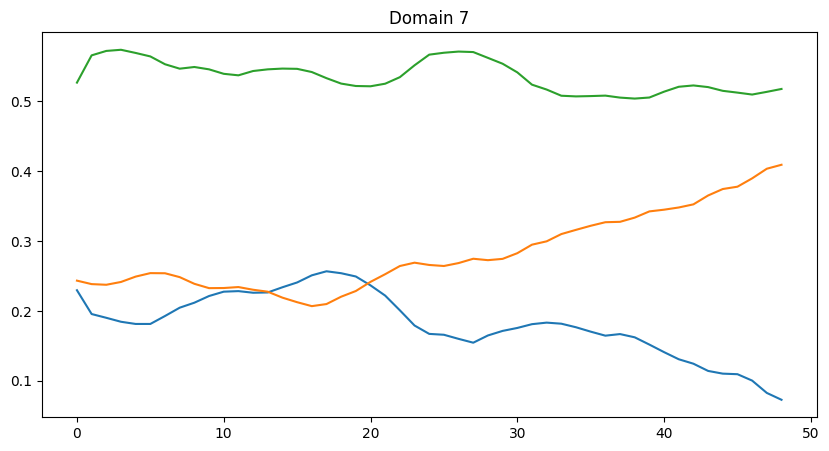

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

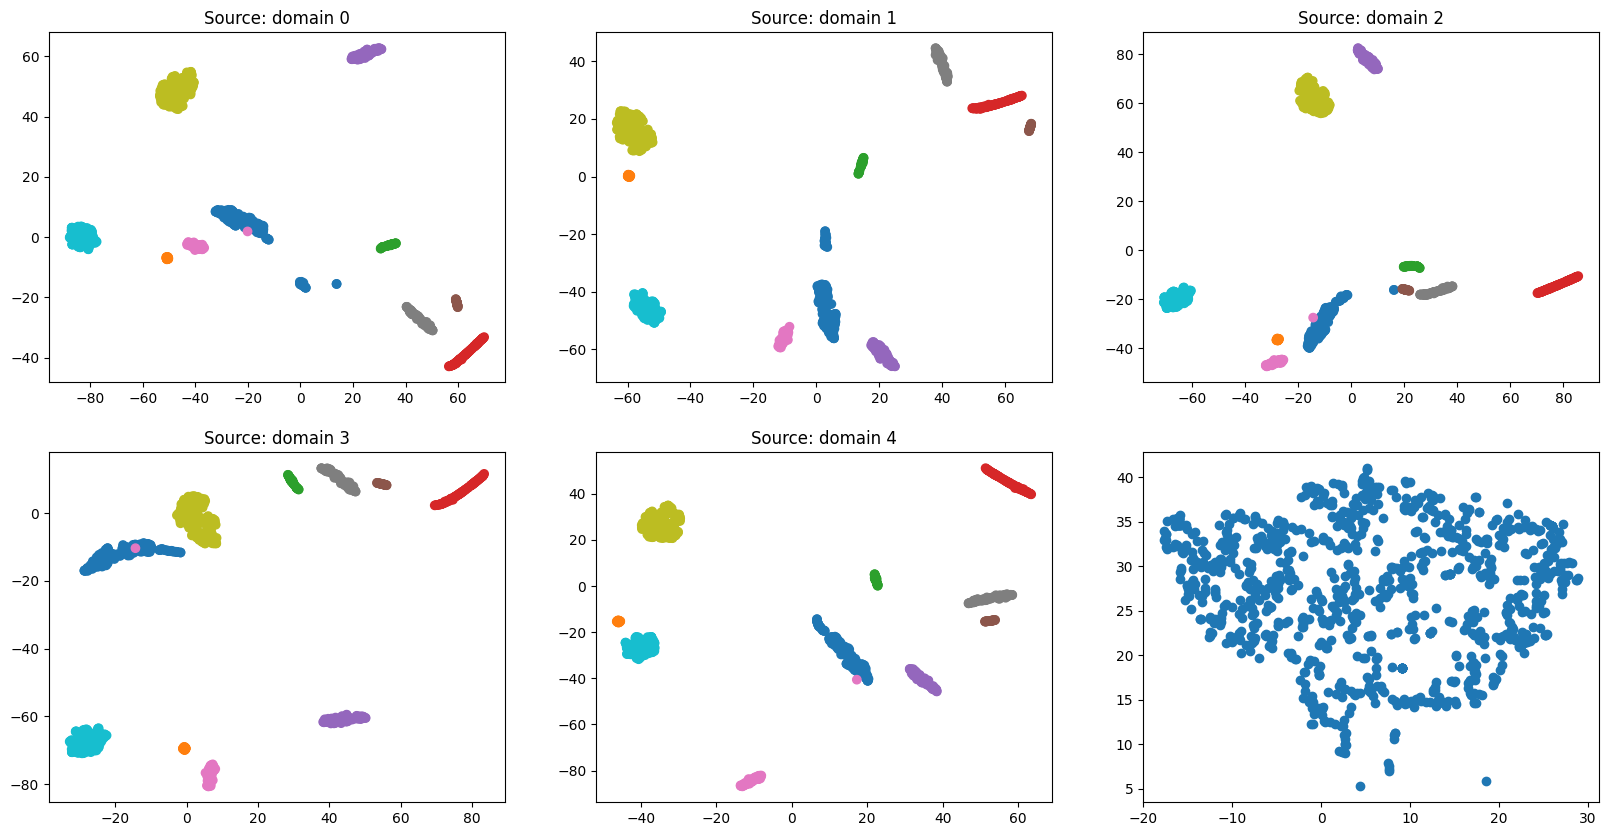

In [21]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(1000)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == n_domains-1)[0]
axes.flatten()[-1].scatter(proj[ind, 0],
               proj[ind, 1])

In [22]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

Xr, Yr = dictionary_target.reconstruct(weights=weights)

tensor([0.0729, 0.4093, 0.5178])


Classification without DA

In [23]:
clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='gini')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.74


DaDiL-E

In [24]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0729999989271164 got 0.84
Atom 1 w/ weight 0.4090000092983246 got 0.789
Atom 2 w/ weight 0.5180000066757202 got 0.784
0.786


DaDiL-R

In [25]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.79


Final optimal transport to adapt domains

In [26]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0729999989271164 got 0.849
Atom 1 w/ weight 0.4090000092983246 got 0.824
Atom 2 w/ weight 0.5180000066757202 got 0.85
0.84


In [27]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.846


## Dictionary learning seperated between sources and target

In [148]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [149]:
criterion = JointWassersteinDistance()

In [150]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [151]:
dictionary_sources.fit(Q_sources,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 6811.979980468751
It 2/60, Loss: 4561.91826171875
It 3/60, Loss: 2949.80390625
It 4/60, Loss: 2065.2195556640627
It 5/60, Loss: 1713.1765380859374
It 6/60, Loss: 1479.4699951171874
It 7/60, Loss: 1339.6915039062499
It 8/60, Loss: 1276.7452880859373
It 9/60, Loss: 1212.3653076171875
It 10/60, Loss: 1163.9464111328125
It 11/60, Loss: 1132.1940673828124
It 12/60, Loss: 1103.9516357421876
It 13/60, Loss: 1085.3390625000002
It 14/60, Loss: 1080.1459228515625
It 15/60, Loss: 1025.7579223632813
It 16/60, Loss: 1015.3780761718749
It 17/60, Loss: 1000.5501708984375
It 18/60, Loss: 1023.8056274414062
It 19/60, Loss: 992.5769653320314
It 20/60, Loss: 978.8472290039061
It 21/60, Loss: 984.0693725585936
It 22/60, Loss: 972.1728637695312
It 23/60, Loss: 955.9900756835939
It 24/60, Loss: 936.7345458984375
It 25/60, Loss: 922.2802612304687
It 26/60, Loss: 926.8438232421875
It 27/60, Loss: 870.6769287109375
It 28/60, Loss: 842.4213256835936
It 29/60, Loss: 825.437353515625
It 30/60, Loss

In [152]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [153]:
names_sources = [f'domain {i}' for i in range(6)]

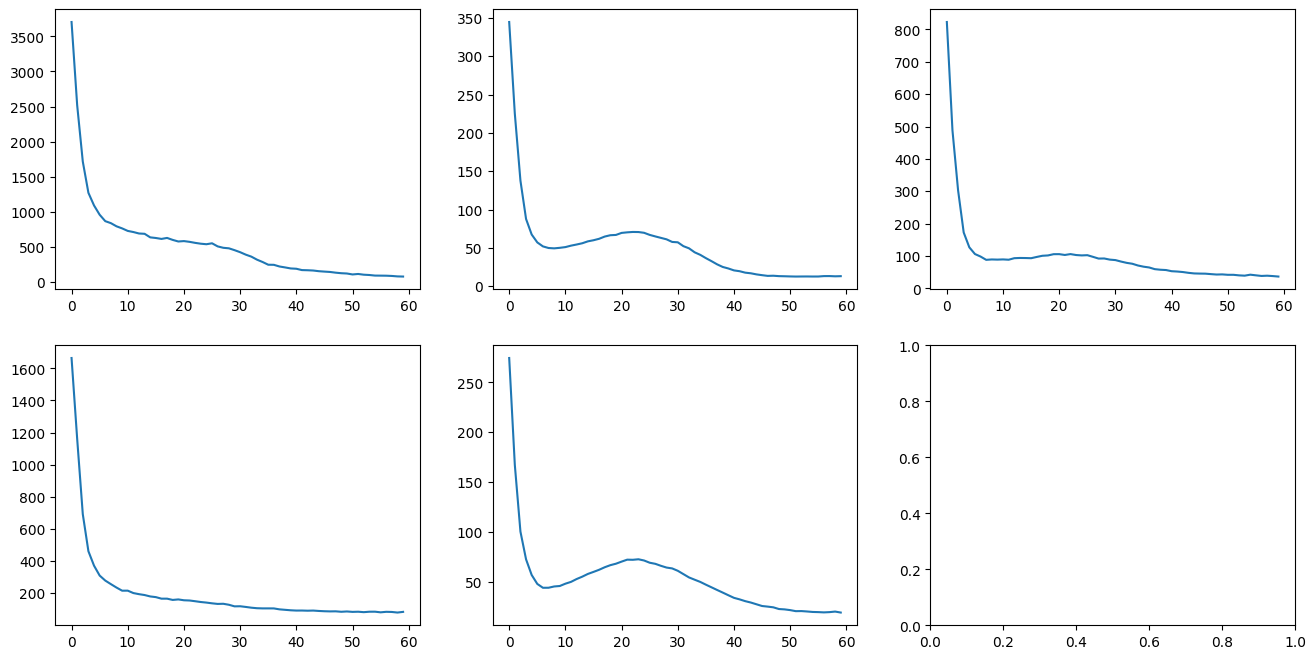

In [154]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

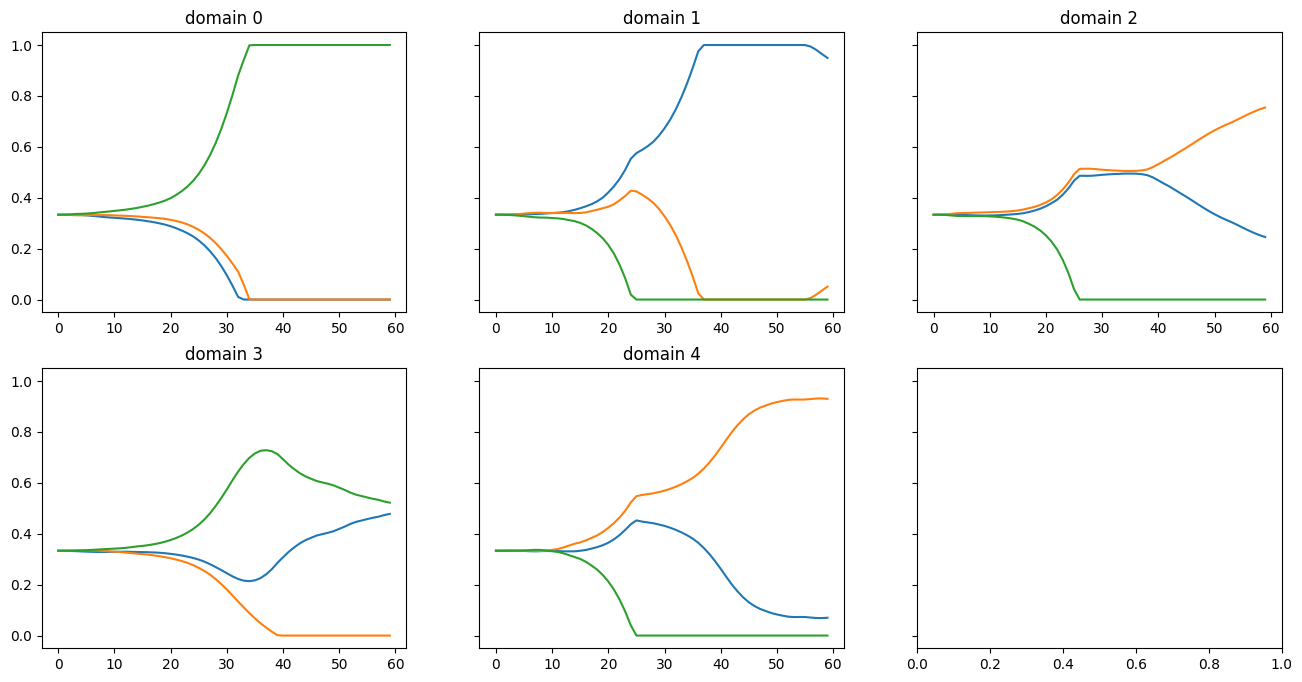

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten()[:-1])):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [156]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [157]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 105.94940643310547
It 2/40, Loss: 102.3138916015625
It 3/40, Loss: 100.70666351318359
It 4/40, Loss: 104.24326782226564
It 5/40, Loss: 105.36407470703125
It 6/40, Loss: 100.97377319335936
It 7/40, Loss: 105.42977294921874
It 8/40, Loss: 113.99273986816408
It 9/40, Loss: 104.43627166748047
It 10/40, Loss: 105.07008666992188
It 11/40, Loss: 99.160302734375
It 12/40, Loss: 106.98026580810547
It 13/40, Loss: 104.40335540771484
It 14/40, Loss: 100.71348724365234
It 15/40, Loss: 110.29284973144533
It 16/40, Loss: 106.6973907470703
It 17/40, Loss: 111.34894104003907
It 18/40, Loss: 107.89900054931641
It 19/40, Loss: 105.51728515625001
It 20/40, Loss: 108.06456146240235
It 21/40, Loss: 109.65324096679689
It 22/40, Loss: 102.43630828857422
It 23/40, Loss: 96.41658020019531
It 24/40, Loss: 112.88636627197266
It 25/40, Loss: 110.97306213378906
It 26/40, Loss: 112.72770233154297
It 27/40, Loss: 102.13374786376954
It 28/40, Loss: 106.38578033447267
It 29/40, Loss: 101.5913070678711
I

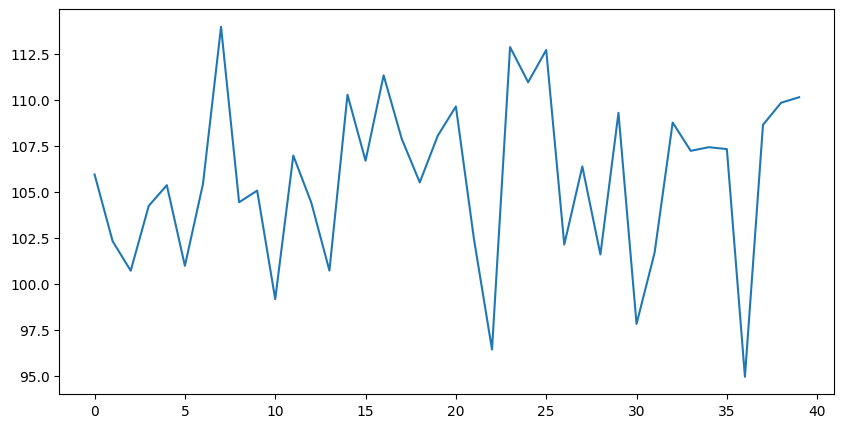

In [158]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

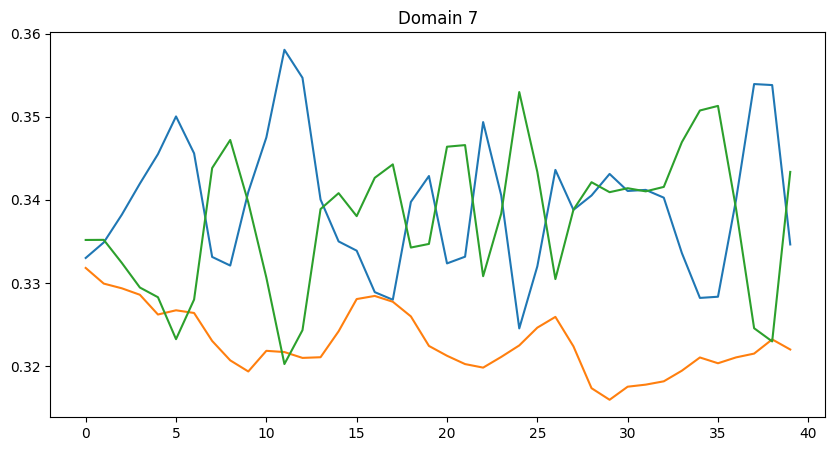

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [160]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3346, 0.3220, 0.3434])


In [161]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [162]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.611


DaDiL-E

In [176]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.168
Atom 1 w/ weight 0.32199999690055847 got 0.478
Atom 2 w/ weight 0.34299999475479126 got 0.521
0.435


DaDiL-R

In [183]:
clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.49


Final optimal transport to adapt domains

In [171]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.436
Atom 1 w/ weight 0.32199999690055847 got 0.701
Atom 2 w/ weight 0.34299999475479126 got 0.681
0.722


In [175]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.658


## Classic Dictionary learning with Online_GMM

In [35]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(sklearn_GMM)

criterion = JointWassersteinDistance()

dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

dictionary.fit(Q,
               n_iter_max=80,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=True,
               batch_size_GMM=batch_size)

It 1/80, Loss: 6269309.699999999
It 2/80, Loss: 4233588.75
It 3/80, Loss: 2866661.45
It 4/80, Loss: 2163310.2
It 5/80, Loss: 1830610.775
It 6/80, Loss: 1668877.275
It 7/80, Loss: 1602477.275
It 8/80, Loss: 1572008.8250000002
It 9/80, Loss: 1549545.875
It 10/80, Loss: 1524968.35
It 11/80, Loss: 1523325.4499999997
It 12/80, Loss: 1507107.0
It 13/80, Loss: 1493637.4249999998
It 14/80, Loss: 1490748.75
It 15/80, Loss: 1455946.75
It 16/80, Loss: 1465063.375
It 17/80, Loss: 1467433.2999999998
It 18/80, Loss: 1452090.7750000001
It 19/80, Loss: 1432055.175
It 20/80, Loss: 1434801.9749999999
It 21/80, Loss: 1420752.0
It 22/80, Loss: 1408668.025
It 23/80, Loss: 1399369.2
It 24/80, Loss: 1388992.2999999998
It 25/80, Loss: 1400547.05
It 26/80, Loss: 1385805.3250000002
It 27/80, Loss: 1367753.65
It 28/80, Loss: 1359886.025
It 29/80, Loss: 1369284.7750000001
It 30/80, Loss: 1353233.875
It 31/80, Loss: 1360643.85
It 32/80, Loss: 1329576.25
It 33/80, Loss: 1326157.225
It 34/80, Loss: 1322383.2
It 35/8

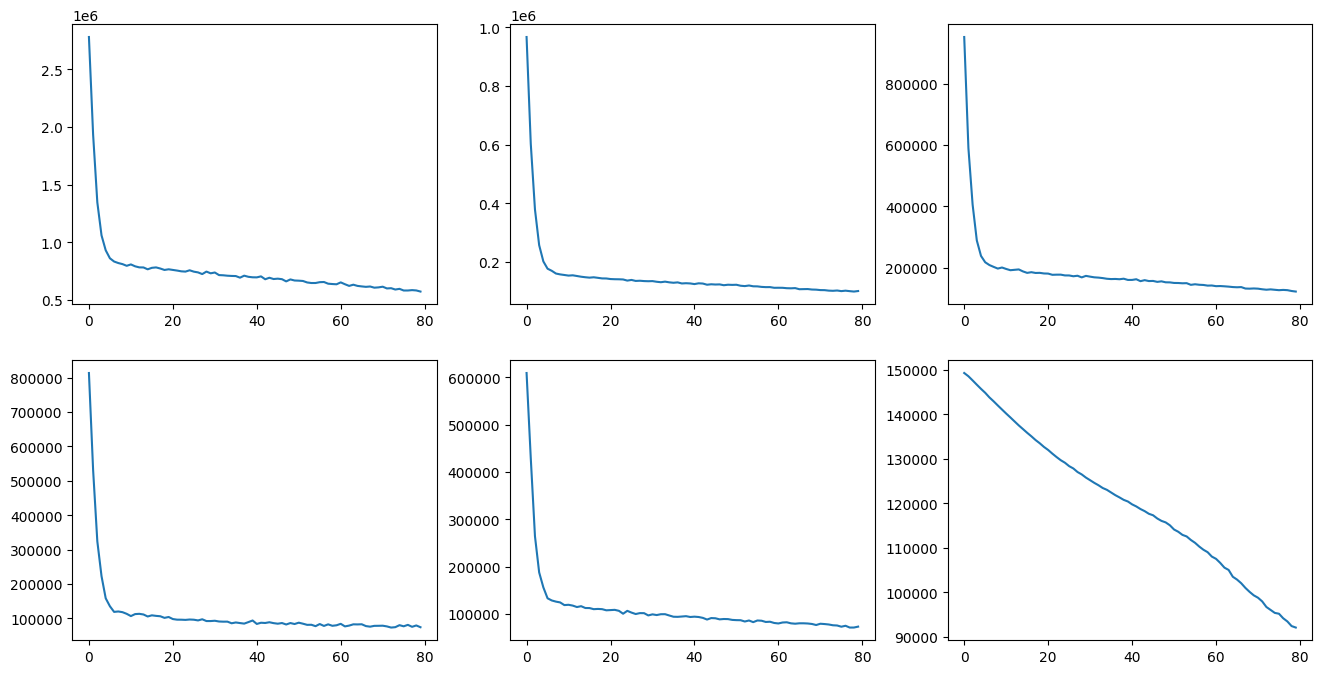

In [36]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

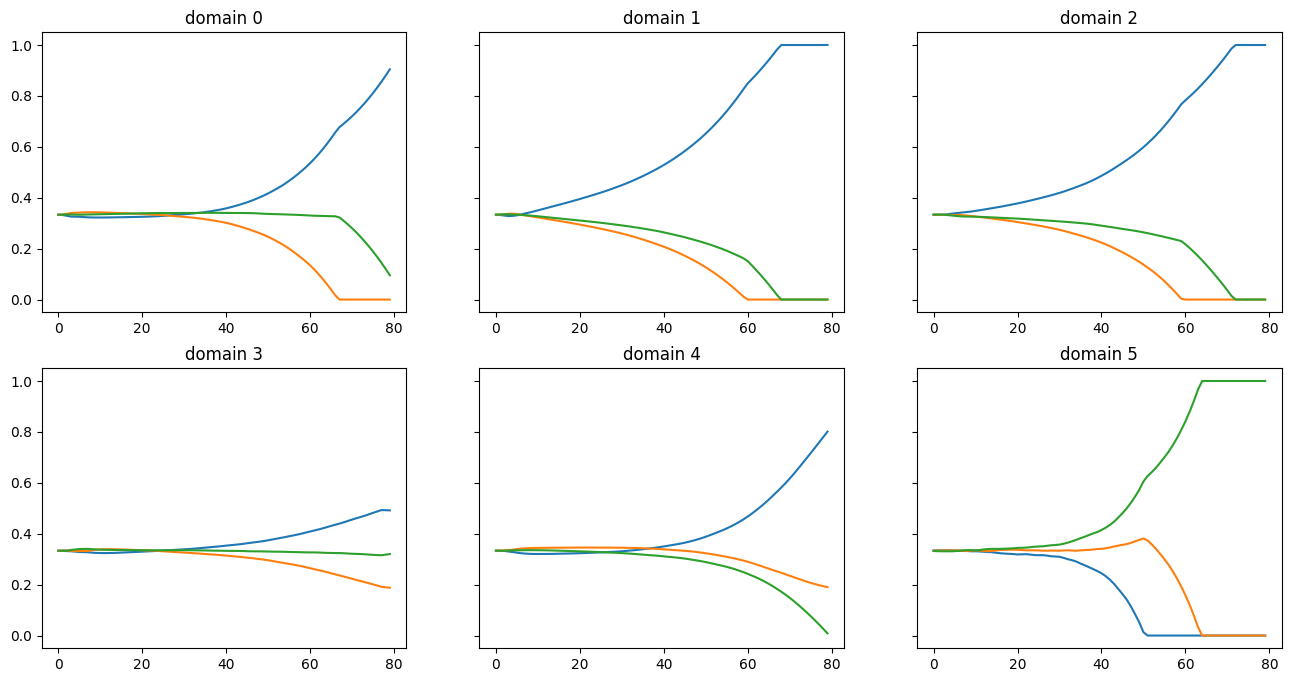

In [37]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [38]:
weights = dictionary.A[-1, :].detach()
#weights = torch.tensor([1/3, 1/3, 1/3])
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

Xr, Yr = dictionary.reconstruct(weights=weights)

tensor([0., 0., 1.])


Classification without DA

In [39]:
clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.749


DaDiL-E

In [45]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.782
Atom 1 w/ weight 0.0 got 0.798
Atom 2 w/ weight 1.0 got 0.671
0.653


DaDiL-R

In [47]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.673


Final optimal transport to adapt domains

In [42]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.839
Atom 1 w/ weight 0.0 got 0.597
Atom 2 w/ weight 1.0 got 0.701
0.592


In [43]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.73


## Classic Dictionary Learning

In [13]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [14]:
criterion = JointWassersteinDistance()

In [15]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=n_classes,
                           n_components=n_atoms,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 6452845.3
It 2/60, Loss: 4229891.25
It 3/60, Loss: 2897649.6499999994
It 4/60, Loss: 2118792.15
It 5/60, Loss: 1794675.15
It 6/60, Loss: 1660355.0750000002
It 7/60, Loss: 1596892.45
It 8/60, Loss: 1544539.6
It 9/60, Loss: 1530882.7
It 10/60, Loss: 1486355.45
It 11/60, Loss: 1487969.375
It 12/60, Loss: 1490947.2000000002
It 13/60, Loss: 1497647.4749999999
It 14/60, Loss: 1455035.4249999998
It 15/60, Loss: 1463183.525
It 16/60, Loss: 1465035.975
It 17/60, Loss: 1427013.4500000002
It 18/60, Loss: 1449760.2
It 19/60, Loss: 1415465.675
It 20/60, Loss: 1417838.825
It 21/60, Loss: 1422355.95
It 22/60, Loss: 1406385.15
It 23/60, Loss: 1382866.175
It 24/60, Loss: 1357839.75
It 25/60, Loss: 1385078.125
It 26/60, Loss: 1357985.1250000002
It 27/60, Loss: 1359678.15
It 28/60, Loss: 1353518.225
It 29/60, Loss: 1333589.95
It 30/60, Loss: 1344369.2000000002
It 31/60, Loss: 1316315.85
It 32/60, Loss: 1330794.9000000001
It 33/60, Loss: 1327914.225
It 34/60, Loss: 1308220.7750000001
It 35/

In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

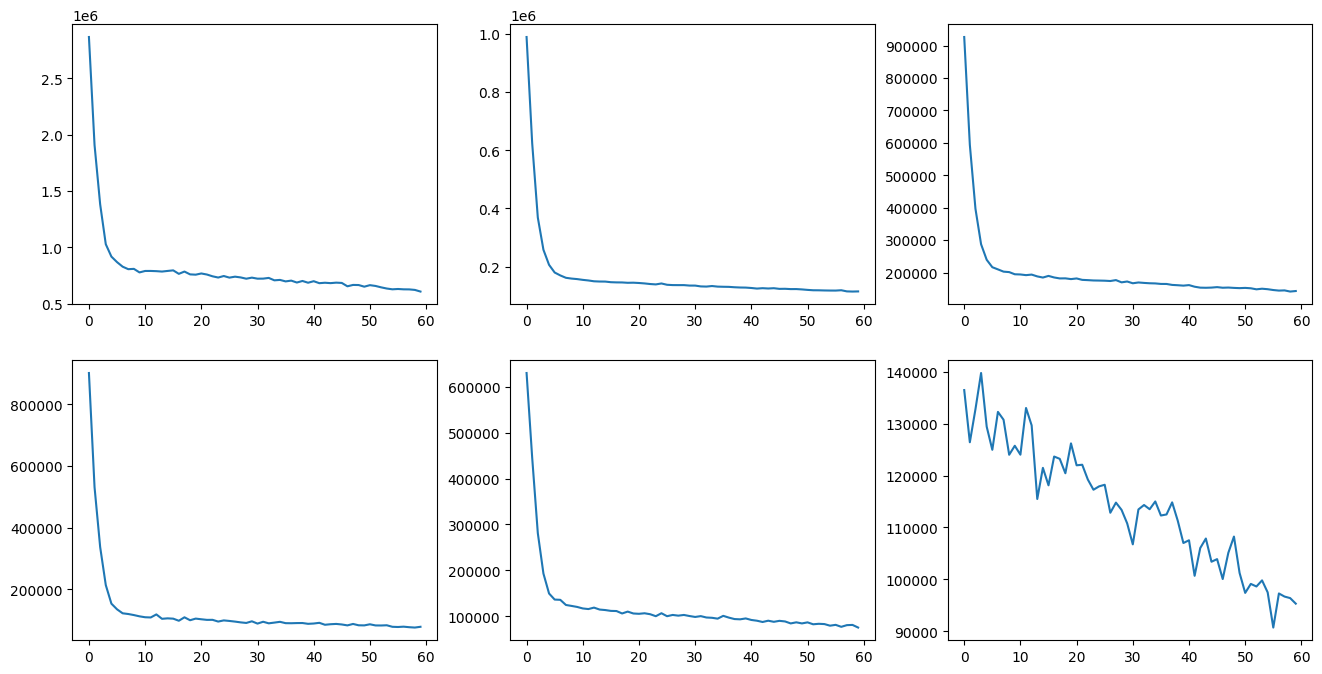

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])

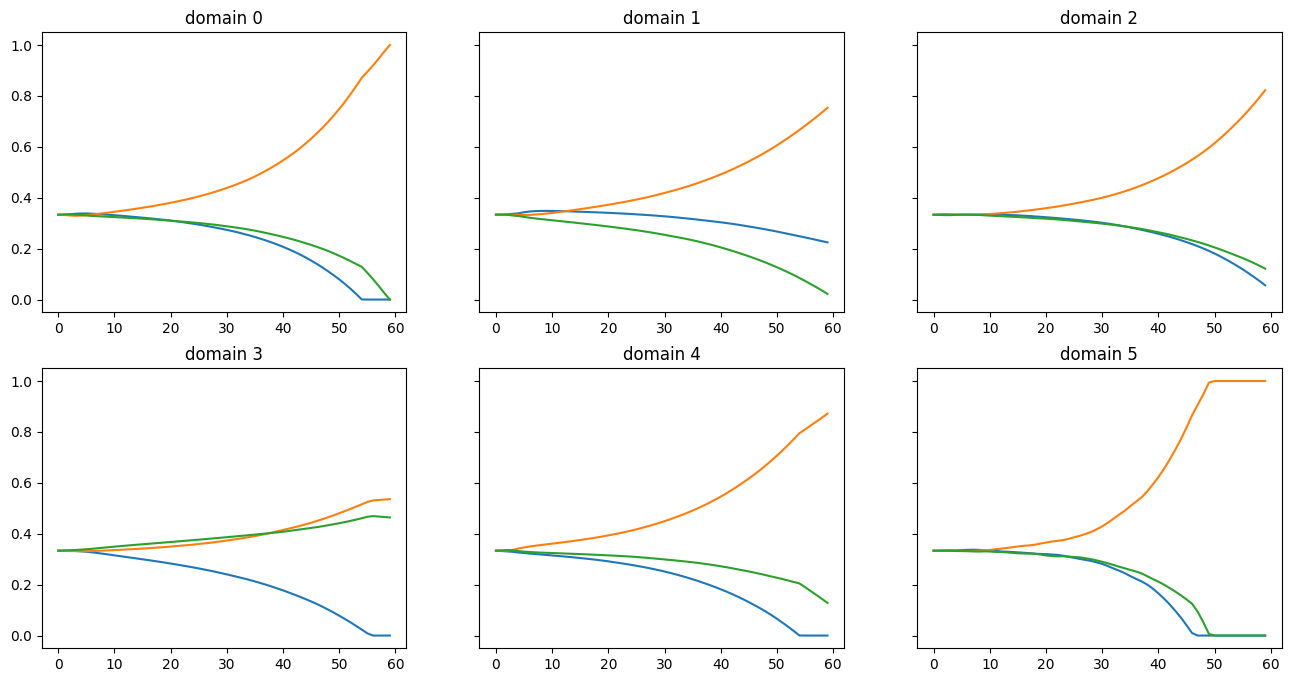

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0., 1., 0.])


In [21]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [22]:
clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.761


DaDiL-E

In [23]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

'''
yp = [np.sum((weights.numpy().reshape(-1, 1) * predictions[:, j, :]), axis = 0).argmax() for j in range(predictions.shape[1])]
yp = np.array(yp)
'''

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.86
Atom 1 w/ weight 1.0 got 0.61
Atom 2 w/ weight 0.0 got 0.848
0.591


DaDiL-R

In [24]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.61


Final optimal transport to adapt domains

In [25]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_t = torch.ones(Xt.shape[0])/Xt.shape[0]

    C = torch.cdist(XP_k, Xt, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_t, C, numItermax=1000000)
    Yt = ot_plan.T @ YP_k

    yt = Yt.argmax(dim=1)
    
    clf.fit(Xt, yt)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.0 got 0.887
Atom 1 w/ weight 1.0 got 0.89
Atom 2 w/ weight 0.0 got 0.891
0.733


In [26]:
weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_t = torch.ones(Xt.shape[0])/Xt.shape[0]

C = torch.cdist(Xr, Xt, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_t, C, numItermax=1000000)
Yt = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt, Yt.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.88
